In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

from pymystem3 import Mystem

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [32]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\marGO.LAPTOP-
[nltk_data]     CEGVK39N\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\marGO.LAPTOP-
[nltk_data]     CEGVK39N\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
def Lemmatize(src: list):
    ''' Лемматизирует переданный датасет
    '''
    text_nomalized = ' '.join(src).lower() 

    m = Mystem()
    lemmas = m.lemmatize(text_nomalized)
    
    return lemmas

In [34]:
data = pd.read_csv('dataframe.csv')
print(data)

      mark                                    text_of_comment
0        1  Сразу отвечаю на вопрос, почему я решила прочи...
1        1  Эта сказка хоть и сказка,но учит всех людей то...
2        1  Несомненно видно мастерство автора, который с ...
3        1  Эта сказка хоть и сказка,но учит всех людей то...
4        1  Несомненно видно мастерство автора, который с ...
...    ...                                                ...
5015     5  Мне кажется что эту книгу должен прочитать каж...
5016     5  Сильно, мощно и талантливо. И глубоко, если см...
5017     5  Ощущение, будто посмотрела фильм ужасов. Реаль...
5018     5  Дом станционного смотрителя в одноименной пове...
5019     5  17 век. Англия.В стране процветает охота на ве...

[5020 rows x 2 columns]


In [35]:
data.dropna(inplace=True)
remove_non_alphabets = lambda x: re.sub(r'[^а-яА-Я]',' ',str(x))

tokenize = lambda x: word_tokenize(x, language = "russian")

ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]

print('remove_non_alphabets')
data['text_of_comment'] = data['text_of_comment'].apply(remove_non_alphabets)

print('tokenize')
data['text_of_comment'] = data['text_of_comment'].apply(tokenize) 

print('stem')
data['text_of_comment'] = data['text_of_comment'].apply(stem)

print('Lemmatize')

for words_list in tqdm(data['text_of_comment']):
    words_list = Lemmatize(words_list)


print('complete')
data['text_of_comment'] = data['text_of_comment'].apply(lambda x: ' '.join(x))

data.dropna(inplace=True)

print(data)

remove_non_alphabets
tokenize
stem
Lemmatize


100%|██████████| 5017/5017 [3:48:39<00:00,  2.73s/it]       

complete
      mark                                    text_of_comment
0        1  сразу отвечаю на вопрос почему я решила прочит...
1        1  эта сказка хоть и сказка но учит всех людей то...
2        1  несомненно видно мастерство автора который с п...
3        1  эта сказка хоть и сказка но учит всех людей то...
4        1  несомненно видно мастерство автора который с п...
...    ...                                                ...
5015     5  мне кажется что эту книгу должен прочитать каж...
5016     5  сильно мощно и талантливо и глубоко если смотр...
5017     5  ощущение будто посмотрела фильм ужасов реальны...
5018     5  дом станционного смотрителя в одноименной пове...
5019     5  век англия в стране процветает охота на ведьм ...

[5017 rows x 2 columns]


In [42]:
stopWords = stopwords.words('russian')

vectorizer = CountVectorizer(stop_words=stopWords)
sparse_matrix = vectorizer.fit_transform(data['text_of_comment']).toarray()
print(sparse_matrix)
sparse_matrix.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(5017, 66822)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(data['mark']), test_size = 0.1, train_size = 0.8)

In [44]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(143, 143)
        self.linear2 = nn.Linear(143, 143)
        self.linear3 = nn.Linear(143, 143)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [45]:
model = LogisticRegression()

In [46]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()

In [48]:
epochs = 9
model.train()
loss_values = []
i = 0.01
for epoch in range(epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters() , lr=i)
    optimizer
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss_values.append(loss.item())
    pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
    acc = pred * 100.0 / len(x_train)
    print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, loss.item(), acc.numpy()))
    if epoch%3 == 0: i+=0.3 
    loss.backward()
    optimizer.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4013x66822 and 143x143)

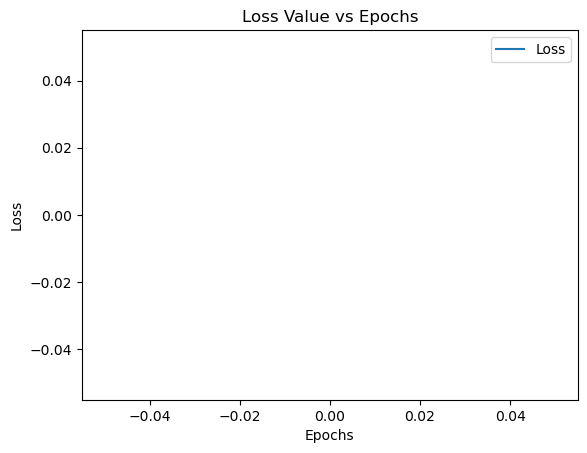

In [49]:
plt.plot(loss_values)
plt.title('Loss Value vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()

In [50]:
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()

In [51]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    loss = criterion(y_pred, y_test)
    pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print ("Accuracy : {}%".format(100*pred/len(x_test)))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (502x66822 and 143x143)